# Example: Evolution of XRD Spectra with Annealing

Abstract:
Hard coatings used to protect engineering components from external loads and harsh environments should ideally be strong and tough. Here we study the fracture toughness, K IC, of Ti1−xAlxN upon annealing by employing micro-fracture experiments on freestanding films. We found that K IC increases by about 11% when annealing the samples at 900 °C, because the decomposition of the supersaturated matrix leads to the formation of nanometer-sized domains, precipitation of hexagonal-structured B4 AlN (with their significantly larger specific volume), formation of stacking faults, and nano-twins. In contrast, for TiN, where no decomposition processes and formation of nanometer-sized domains can be initiated by an annealing treatment, the fracture toughness K IC remains roughly constant when annealed above the film deposition temperature. As the increase in K IC found for Ti1−xAlxN upon annealing is within statistical errors, we carried out complementary cube corner nanoindentation experiments, which clearly show reduced (or even impeded) crack formation for annealed Ti1−xAlxN as compared with their as-deposited counterpart. The ability of Ti1−xAlxN to maintain and even increase the fracture toughness up to high temperatures in combination with the concomitant age hardening effects and excellent oxidation resistance contributes to the success of this type of coatings.

https://www-nature-com.turing.library.northwestern.edu/articles/s41598-017-16751-1


# Lesson: Random(?) Alloy

### Simulating a Random Alloy
### Visualization
### Simulating a Phase Segregated Alloy
### Sampling in Characterization





# Approach to Simulating a Random Alloy

In this exercise we simulate one-dimensional alloys composed of atoms of type A and B. The goal is to compare the composition statistics of a random alloy to those of a segregated microstructure, using simple assumptions that focus on the effects of sampling rather than on atomistic realism.

### Simulation Cases
1. **Phase 0 (random alloy):**  
   - We build a chain of $N$ atoms, each atom being A with probability $x_A$ and B with probability $1-x_A$.  
   - To eliminate fluctuations in the *total* composition, the simulation enforces an **exact count** of A atoms equal to $\mathrm{round}(N \cdot x_A)$.  
   - The A and B atoms are then shuffled randomly along the chain.

**Code:**
    
    block[:k] = True

    block[k:] = False
    
    rng.shuffle(block)

2. **Segregated material (Phase 1 + Phase 2):**  
   - The system has the same average composition $x_A$ as the random alloy.  
   - It is divided into alternating domains of fixed size (measured in number of atoms).  
   - **Phase 1 domains** are enriched in A:  
     $$
     x_A^{(1)} = x_A + \Delta
     $$
     where $\Delta$ is the enrichment.  
   - **Phase 2 domains** are depleted in A so that the global average composition remains $x_A$:  
     $$
     x_A^{(2)} = 2x_A - x_A^{(1)}.
     $$
   - Each domain is assigned an **exact integer count** of A atoms using the “largest remainder” method, so that:  
     $$
     \sum_i n_A^{(i)} = \mathrm{round}(N \cdot x_A).
     $$  
   - Within each domain, the exact number of A and B atoms are randomly permuted.

---

### Key Variables
- **$N$**: total number of atoms in the chain.  
- **$x_A$**: target average fraction of A atoms.  
- **$\Delta$**: enrichment of Phase 1 domains in A.  
- **Domain size**: number of atoms per domain (applies to both Phase 1 and Phase 2).  
- **Seed**: random number seed for reproducibility.

---

### Outputs
The simulation reports the measured composition fractions $x_A$ for:
- **Phase 0** (random alloy)  
- **Phase 1 domains**  
- **Phase 2 domains**  
- **All atoms in the segregated case**  

Sanity checks confirm that both the random alloy and the segregated microstructure reproduce the exact global composition $x_A$.

---

### Notes
- This version uses **exact totals** rather than binomial sampling, to focus on how composition appears when probed at different resolution scales in later analysis.  
- Performance is efficient for $N \approx 10^6$ atoms, since construction is block-wise by domain and vectorized within each block.


# Simulation

## Import Libraries

In [47]:
#Import libraries
import numpy as np
import pandas as pd
from dataclasses import dataclass

## Explanation of Random Alloy Simulation Code

The helper function `fixed_count_block` used in the simulation to create a 1D array representing a segment of the alloy with a precisely fixed number of A atoms.

*   **`def fixed_count_block(L: int, k: int, rng: np.random.Generator) -> np.ndarray:`**: This defines the function `fixed_count_block` which takes three arguments:
    *   `L`: An integer representing the **total length** (number of atoms) of the block or segment being created.
    *   `k`: An integer representing the **exact number of A atoms** (represented by `True`) that must be present in this block.
    *   `rng`: A NumPy random number generator object used to ensure the shuffling is reproducible if a seed is set.
    *   `-> np.ndarray`: This indicates that the function returns a NumPy array.
*   **`if k < 0 or k > L:`**: This is a check to make sure the requested number of A atoms (`k`) is valid for the given block length (`L`). You can't have negative atoms or more A atoms than the total number of atoms in the block. If it's invalid, it raises a `ValueError`.
*   **`block = np.empty(L, dtype=bool)`**: This creates an empty NumPy array of boolean values with a length equal to `L`. This array will store the representation of the atoms in the block (`True` for A, `False` for B).
*   **`block[:k] = True`**: This sets the first `k` elements of the `block` array to `True`, representing the A atoms.
*   **`block[k:] = False`**: This sets the remaining elements of the `block` array (from index `k` to the end) to `False`, representing the B atoms. At this point, the array has exactly `k` True values and `L-k` False values, but the A atoms are all at the beginning.
*   **`rng.shuffle(block)`**: This is the crucial step for creating the "random alloy" within this block. It randomly shuffles the elements of the `block` array. This distributes the `k` A atoms and `L-k` B atoms randomly throughout the block while maintaining the exact count of each.
*   **`return block`**: The function returns the shuffled NumPy array, which is the simulated 1D segment of the alloy with a fixed number of A atoms.

In the context of the larger simulation code, this `fixed_count_block` function is used to build the overall alloy chain. For the "random alloy" case (Phase 0), it's called once with the total number of atoms (`N_total`) and the rounded target number of A atoms (`round(N_total * xA_avg)`) to create the entire random chain. For the "segregated" case, it's called for each domain with the domain size and the calculated exact number of A atoms for that specific domain.

## Simulation Code: Random and Segregated

In [52]:
# Random Alloy & Segregated Domains (1D) — fast, fixed-count version
#
# What this does
#  - Simulates a 1D chain of N atoms (A/B).
#  - Case "phase_0": random alloy with EXACT total count of A = round(N * xA_avg).
#  - Case "segregated": equal-sized domains alternating phase_1 and phase_2.
#       * phase_1 is enriched in A by `enrichment` (absolute fraction).
#       * phase_2 composition is set to preserve overall xA_avg.
#       * Each domain has an EXACT integer count of A; totals match exactly.
#  - Reports x_A for: phase_0 (whole), segregated (whole), and separately for phase_1 and phase_2 domains.
#
# Performance notes
#  - Uses block-wise construction: per domain we build a boolean block with exactly k Trues,
#    then randomly permute within the block (fast) rather than sampling indices (faster for large N).
#  - Loop is over domains only (O(N / domain_size)); for N=1e6 and domain_size=200, ~5000 iterations is fine.
#
# You can change parameters in the "USER PARAMETERS" section.


# ----------------------------- USER PARAMETERS ----------------------------- #
N_total        = 1_000_000  # total number of atoms
xA_avg         = 0.5       # target average fraction of A in the whole material
enrichment     = 0.1       # absolute enrichment of A in phase_1 over the average
domain_size    = 10000        # atoms per domain (equal-sized; last domain may be shorter)
seed           = 123        # RNG seed for reproducibility
# --------------------------------------------------------------------------- #

rng = np.random.default_rng(seed)

@dataclass
class SimResult:
    name: str
    xA_measured: float
    n_atoms: int

def fixed_count_block(L: int, k: int, rng: np.random.Generator) -> np.ndarray:
    """
    Build a boolean block of length L with exactly k True entries (A atoms),
    randomly permuted (uniform over all C(L,k) arrangements).
    """
    if k < 0 or k > L:
        raise ValueError(f"fixed_count_block: k must be in [0, {L}], got {k}")
    block = np.empty(L, dtype=bool)
    # Fill first k with True, remaining with False, then shuffle:
    block[:k] = True
    block[k:] = False
    rng.shuffle(block)
    return block

def largest_remainder_counts(lengths: np.ndarray, fractions: np.ndarray, total_target: int) -> np.ndarray:
    """
    For domain lengths `lengths` and desired per-domain fractions `fractions`, compute an integer
    count of A in each domain so that:
      - counts[i] ≈ lengths[i] * fractions[i]
      - sum(counts) = total_target
    Uses the "largest remainder" (a.k.a. Hamilton) method.
    """
    raw = lengths * fractions
    floors = np.floor(raw).astype(int)
    remainder = raw - floors
    counts = floors.copy()
    delta = total_target - counts.sum()

    if delta > 0:
        # Give +1 to the domains with the largest remainders
        idx = np.argpartition(-remainder, delta-1)[:delta]
        counts[idx] += 1
    elif delta < 0:
        # Take -1 from domains with the smallest remainders (i.e., largest (1 - remainder))
        # Equivalently, subtract from domains with the smallest remainder first.
        m = -delta
        idx = np.argpartition(remainder, m-1)[:m]
        # Ensure we don't push below 0 (shouldn't happen for reasonable inputs)
        counts[idx] -= 1
        if (counts < 0).any():
            raise RuntimeError("largest_remainder_counts produced negative counts; check inputs.")
    # Final guard: keep within [0, lengths[i]]
    counts = np.clip(counts, 0, lengths)
    # If clipping broke the total, last-resort nudge (rare edge case)
    diff = total_target - counts.sum()
    if diff != 0:
        # Adjust diff by scanning domains where we can still add/subtract
        if diff > 0:
            for i in np.argsort(-(lengths - counts)):  # domains with room first
                add = min(diff, lengths[i] - counts[i])
                counts[i] += add
                diff -= add
                if diff == 0: break
        else:
            diff = -diff
            for i in np.argsort(-counts):  # domains with more to give first
                sub = min(diff, counts[i])
                counts[i] -= sub
                diff -= sub
                if diff == 0: break
        if diff != 0:
            raise RuntimeError("Could not reconcile totals after clipping.")
    return counts

def build_phase0_fixed(N: int, xA_avg: float, rng: np.random.Generator) -> np.ndarray:
    """Random alloy with EXACT total count of A = round(N * xA_avg)."""
    kA = int(round(N * xA_avg))
    return fixed_count_block(N, kA, rng)

def build_segregated_fixed(N: int, xA_avg: float, enrichment: float, domain_size: int, rng: np.random.Generator):
    """
    Alternating domains: phase_1 (enriched) and phase_2 (depleted) with fixed counts per domain
    and exact total matching round(N * xA_avg).
    Returns (is_A, phase1_mask, phase2_mask, xA_p1_nominal, xA_p2_nominal)
    """
    # Start from requested phase_1 composition and compute complementary phase_2
    xA_p1 = xA_avg + enrichment
    xA_p1 = min(max(xA_p1, 0.0), 1.0)
    xA_p2 = 2 * xA_avg - xA_p1
    # If complementary goes out of [0,1], clip and re-adjust xA_p1 to preserve average
    if xA_p2 < 0.0:
        xA_p2 = 0.0
        xA_p1 = 2 * xA_avg - xA_p2
    elif xA_p2 > 1.0:
        xA_p2 = 1.0
        xA_p1 = 2 * xA_avg - xA_p2
    # Final clamp
    xA_p1 = float(np.clip(xA_p1, 0.0, 1.0))
    xA_p2 = float(np.clip(xA_p2, 0.0, 1.0))

    # Domain bookkeeping
    n_domains = int(np.ceil(N / domain_size))
    lengths = np.full(n_domains, domain_size, dtype=int)
    lengths[-1] = N - domain_size * (n_domains - 1) if n_domains > 0 else 0

    # 0 -> phase_1, 1 -> phase_2, alternating
    types = np.arange(n_domains) % 2  # 0,1,0,1,...
    fracs = np.where(types == 0, xA_p1, xA_p2)

    # Exact per-domain counts using largest-remainder, with exact TOTAL fixed to round(N * xA_avg)
    total_target = int(round(N * xA_avg))
    counts = largest_remainder_counts(lengths, fracs, total_target)

    # Assemble chain
    is_A = np.empty(N, dtype=bool)
    phase1_mask = np.zeros(N, dtype=bool)
    phase2_mask = np.zeros(N, dtype=bool)

    start = 0
    for L, t, k in zip(lengths, types, counts):
        end = start + L
        block = fixed_count_block(L, k, rng)  # exact k As in this domain
        is_A[start:end] = block
        if t == 0:
            phase1_mask[start:end] = True
        else:
            phase2_mask[start:end] = True
        start = end

    return is_A, phase1_mask, phase2_mask, xA_p1, xA_p2

# ------------------------------- SIMULATIONS ------------------------------- #

# Case: phase_0 random alloy (exact total A)
atoms_phase0 = build_phase0_fixed(N_total, xA_avg, rng)
res_phase0 = SimResult(
    name="phase_0 (random alloy, fixed total A)",
    xA_measured=atoms_phase0.mean(),
    n_atoms=N_total
)

# Case: segregated (phase_1 + phase_2) with fixed counts per domain and exact overall total
atoms_seg, mask_p1, mask_p2, xA_p1_nominal, xA_p2_nominal = build_segregated_fixed(
    N_total, xA_avg, enrichment, domain_size, rng
)

# Measured compositions
xA_p1_meas = atoms_seg[mask_p1].mean() if mask_p1.any() else np.nan
xA_p2_meas = atoms_seg[mask_p2].mean() if mask_p2.any() else np.nan
xA_seg_meas = atoms_seg.mean()

res_phase1 = SimResult("phase_1 (domains, fixed counts)", float(xA_p1_meas), int(mask_p1.sum()))
res_phase2 = SimResult("phase_2 (domains, fixed counts)", float(xA_p2_meas), int(mask_p2.sum()))
res_seg_all = SimResult("segregated (all atoms)", float(xA_seg_meas), N_total)

# ------------------------------- REPORTING -------------------------------- #

df = pd.DataFrame([
    {"Case": res_phase0.name, "Atoms": res_phase0.n_atoms, "x_A (measured)": res_phase0.xA_measured, "x_A target": xA_avg},
    {"Case": res_phase1.name, "Atoms": res_phase1.n_atoms, "x_A (measured)": res_phase1.xA_measured, "x_A (nominal)": xA_p1_nominal},
    {"Case": res_phase2.name, "Atoms": res_phase2.n_atoms, "x_A (measured)": res_phase2.xA_measured, "x_A (nominal)": xA_p2_nominal},
    {"Case": res_seg_all.name, "Atoms": res_seg_all.n_atoms, "x_A (measured)": res_seg_all.xA_measured, "x_A target": xA_avg},
])

# Pretty print
with pd.option_context("display.float_format", "{:.6f}".format):
    print(df)

# Quick sanity checks
assert atoms_phase0.sum() == int(round(N_total * xA_avg)), "phase_0 total A mismatch"
assert atoms_seg.sum()   == int(round(N_total * xA_avg)), "segregated total A mismatch"
print("\nSanity checks passed: exact totals enforced.")



                                    Case    Atoms  x_A (measured)  x_A target  \
0  phase_0 (random alloy, fixed total A)  1000000        0.500000    0.500000   
1        phase_1 (domains, fixed counts)   500000        0.600000         NaN   
2        phase_2 (domains, fixed counts)   500000        0.400000         NaN   
3                 segregated (all atoms)  1000000        0.500000    0.500000   

   x_A (nominal)  
0            NaN  
1       0.600000  
2       0.400000  
3            NaN  

Sanity checks passed: exact totals enforced.


# Uniform Alloy Visualization

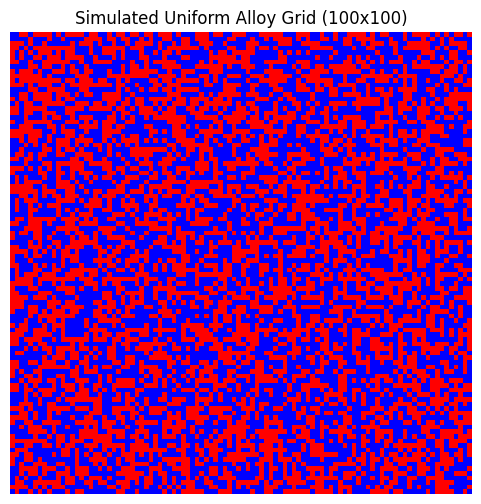

In [53]:
# Assuming atoms_phase0 is available from the main simulation

# Reshape the 1D array into a 2D grid
grid_size = 100
# Ensure there are enough atoms for the requested grid size
if atoms_phase0.size < grid_size * grid_size:
    print(f"Warning: Not enough atoms ({atoms_phase0.size}) to fill a {grid_size}x{grid_size} grid. Using available data.")
    # Use as much data as possible to form a grid
    grid_size = int(np.sqrt(atoms_phase0.size))
    if grid_size == 0:
        print("Not enough atoms to form even a 1x1 grid.")
        atoms_2d = np.zeros((1,1), dtype=bool) # Default to a minimal grid
    else:
        atoms_2d = atoms_phase0[:grid_size*grid_size].reshape((grid_size, grid_size))
else:
    atoms_2d = atoms_phase0[:grid_size*grid_size].reshape((grid_size, grid_size))


# Create a color map: True (A) is red, False (B) is blue
cmap = plt.cm.colors.ListedColormap(['blue', 'red'])

# Display the grid as an image, only if atoms_2d is not empty
if atoms_2d.size > 0:
    plt.figure(figsize=(6, 6))
    plt.imshow(atoms_2d, cmap=cmap, interpolation='nearest')
    plt.title(f'Simulated Uniform Alloy Grid ({grid_size}x{grid_size})')
    plt.axis('off') # Hide axes
    plt.show()
else:
    print("Could not create a valid grid for visualization.")

## Discussion Points

# Segregated Alloy Visualization

## Domain Construction with Fallback Simulation

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure atoms_seg and domain_size exist (fallback if running cell alone)
try:
    atoms_seg_data = atoms_seg
    domain_size_val = domain_size
    # Get the masks for Phase 1 and Phase 2
    mask_p1_data = mask_p1
    mask_p2_data = mask_p2
except NameError:
    print("atoms_seg, domain_size, mask_p1, or mask_p2 not found. Generating fallback segregated data.")
    N_total_fallback = 20000 # Smaller size for quick fallback
    xA_avg_fallback = 0.5
    enrichment_fallback = 0.1
    domain_size_fallback = 100
    seed_fallback = 123
    rng_fallback = np.random.default_rng(seed_fallback)
    atoms_seg_data, mask_p1_data, mask_p2_data, _, _ = build_segregated_fixed(
        N_total_fallback, xA_avg_fallback, enrichment_fallback, domain_size_fallback, rng_fallback
    )
    domain_size_val = domain_size_fallback


# Extract a single Phase 1 and a single Phase 2 domain
# Find the start and end indices of the first Phase 1 domain
p1_indices = np.where(mask_p1_data)[0]
if p1_indices.size > 0:
    p1_start = p1_indices[0]
    p1_end = p1_start + domain_size_val
    # Ensure we don't go out of bounds
    if p1_end > atoms_seg_data.size:
        p1_end = atoms_seg_data.size
    p1_domain_data = atoms_seg_data[p1_start:p1_end]
else:
    print("Warning: No Phase 1 domains found.")
    p1_domain_data = np.array([], dtype=bool)


# Find the start and end indices of the first Phase 2 domain
p2_indices = np.where(mask_p2_data)[0]
if p2_indices.size > 0:
    p2_start = p2_indices[0]
    p2_end = p2_start + domain_size_val
    # Ensure we don't go out of bounds
    if p2_end > atoms_seg_data.size:
        p2_end = atoms_seg_data.size
    p2_domain_data = atoms_seg_data[p2_start:p2_end]
else:
    print("Warning: No Phase 2 domains found.")
    p2_domain_data = np.array([], dtype=bool)


# Reshape the 1D domain arrays into square grids
grid_width = domain_size_val
# Ensure enough data for a square grid
if p1_domain_data.size < grid_width * grid_width:
     print(f"Warning: Not enough data in Phase 1 domain ({p1_domain_data.size}) for a {grid_width}x{grid_width} grid. Using a smaller grid.")
     grid_width_p1 = int(np.sqrt(p1_domain_data.size))
     p1_grid = p1_domain_data[:grid_width_p1*grid_width_p1].reshape((grid_width_p1, grid_width_p1))
else:
    p1_grid = p1_domain_data[:grid_width*grid_width].reshape((grid_width, grid_width))

if p2_domain_data.size < grid_width * grid_width:
     print(f"Warning: Not enough data in Phase 2 domain ({p2_domain_data.size}) for a {grid_width}x{grid_width} grid. Using a smaller grid.")
     grid_width_p2 = int(np.sqrt(p2_domain_data.size))
     p2_grid = p2_domain_data[:grid_width_p2*grid_width_p2].reshape((grid_width_p2, grid_width_p2))
else:
    p2_grid = p2_domain_data[:grid_width*grid_width].reshape((grid_width, grid_width))


## Visualize Non-Uniform Alloy Domains

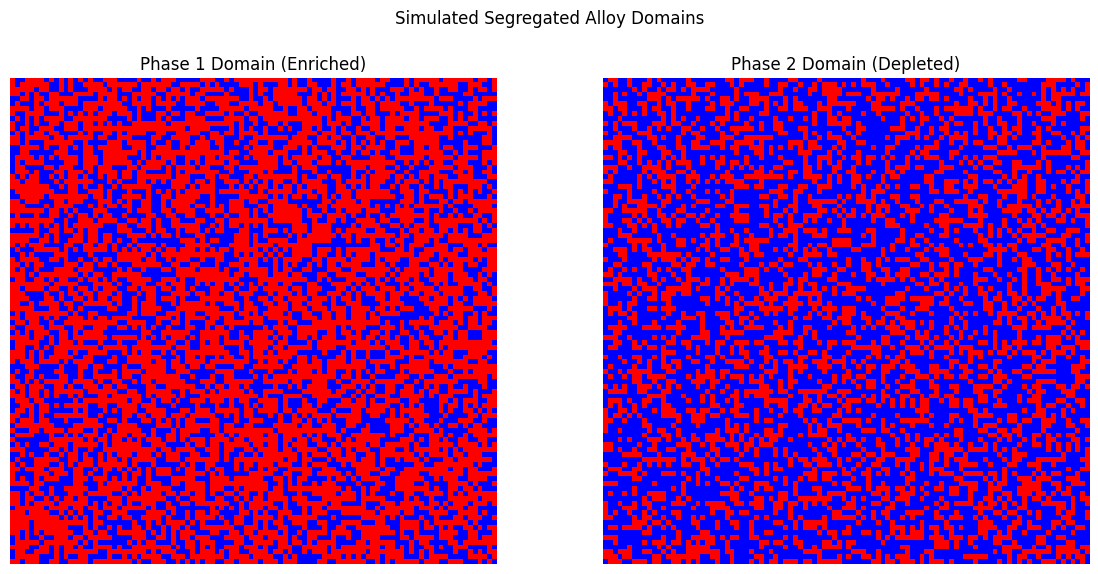

In [54]:
# Create a color map: True (A) is red, False (B) is blue
cmap = plt.cm.colors.ListedColormap(['blue', 'red'])

# Display the grids side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Phase 1 domain
axes[0].imshow(p1_grid, cmap=cmap, interpolation='nearest')
axes[0].set_title('Phase 1 Domain (Enriched)')
axes[0].axis('off') # Hide axes

# Plot Phase 2 domain
axes[1].imshow(p2_grid, cmap=cmap, interpolation='nearest')
axes[1].set_title('Phase 2 Domain (Depleted)')
axes[1].axis('off') # Hide axes

plt.suptitle('Simulated Segregated Alloy Domains')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

## Discussion Points

# Analysis of Alloy Composition by Sampling (APT-Inspired)

In atom probe tomography (APT), the sample is reconstructed in 3D and analyzed by dividing it into **voxels of equal atom counts**.  
Each voxel’s composition $x_A$ (fraction of A atoms) is then measured, and a histogram of these voxel compositions provides insight into **alloy uniformity**:

- A **truly random alloy** should follow a **binomial distribution** of voxel compositions.  
- A **segregated alloy** will deviate, showing broader distributions or even multimodal features when the voxel size is comparable to the domain size.

---


## Measurement Procedure

1. **Input**: The simulated atom sequence from either:
   - **Phase 0 (random alloy)** — average composition $x_A$.  
   - **Segregated alloy** — alternating domains enriched/depleted in A but with the same overall $x_A$.  

2. **Voxelization**:  
   - Atoms are grouped into voxels containing a fixed number of atoms (`voxel_size`).  
   - Several sampling strategies are possible:
     - **Disjoint** (non-overlapping contiguous voxels).  
     - **Sliding** (overlapping windows with a step size).  
     - **Random, no replacement** (random disjoint voxels).  
     - **Bootstrap** (random contiguous voxels with replacement).  

   In this exercise, we typically start with **disjoint sampling** for clarity.

3. **Histogram vs. Theory**:  
   - The measured voxel compositions are binned from 0% to 100% A.  
   - The **theoretical binomial distribution** for a random alloy with average $x_A$ and voxel size $n$ is:  
     $$
     P(k) = \binom{n}{k} (x_A)^k (1 - x_A)^{n-k},
     $$
     where $k$ is the number of A atoms in a voxel and $n = \text{voxel size}$.
   - The binomial curve is scaled to match the **total number of voxels** so that areas are directly comparable.

---

### Outputs
- A histogram (bars) of the **measured voxel compositions**.  
- A **green line** representing the scaled binomial distribution for a random alloy.  
- A **logarithmic y-axis** to highlight the low-probability tails.  
- Diagnostic printout of mean and variance for measured vs. theoretical distributions.

---

### Extensions
- By varying the voxel size, students can see how sensitivity to segregation changes with resolution.  
- By comparing **phase 0** and **segregated cases**, students can directly observe how domain structure broadens the composition distribution.  
- The same framework supports sweeping the enrichment of Phase 1 (e.g., $x_A^{(1)} = 0.50 \to 0.40$) and overlaying multiple curves to visualize systematic changes.

## Uniform Alloy Sampling Cod with Back-Up Simulation

In [55]:
# Analysis of voxel composition histograms vs binomial theory (scaled + log plot)
# for a Uniform (Random) Alloy with interactive controls.

import matplotlib.pyplot as plt
from math import lgamma, log, exp
import numpy as np
from scipy.stats import norm # Import norm for Gaussian distribution
import ipywidgets as widgets
from ipywidgets import interact, Layout

# Ensure simulation building functions are available (assuming they are defined elsewhere)
# We only need build_phase0_fixed and fixed_count_block for the uniform case.
# from your_simulation_module import build_phase0_fixed, fixed_count_block


# ----------------------------- FIXED PARAMETERS ---------------------------- #
N_total        = 1_000_000  # total number of atoms (kept large for good statistics)
seed           = 7          # RNG seed
sampling_mode = 'disjoint' # Fixed sampling mode for simplicity
# --------------------------------------------------------------------------- #

rng = np.random.default_rng(seed)

# Make atoms_phase0 globally accessible
atoms_phase0 = None

# Define the plotting function that takes widget values as arguments
def plot_uniform_alloy_distribution(xA_avg, voxel_size):
    # Clear previous plots if they exist, to avoid overlaying multiple plots in the interactive output area
    plt.close('all')

    global atoms_phase0 # Declare atoms_phase0 as global

    # ----------------------- RUN THE SIMULATION (Phase 0: Random Alloy) ------------------------ #
    is_A = build_phase0_fixed(N_total, xA_avg, rng)
    atoms_phase0 = is_A # Update the global atoms_phase0 variable
    N = is_A.size
    A_int = is_A.view(np.int8)

    # -------------------------- VOXEL SAMPLING LOGIC (Disjoint) --------------------------- #
    def voxel_sums_disjoint(A_int, voxel_size):
        n_full = N // voxel_size
        if n_full == 0: return np.array([], dtype=float)
        cs = np.empty(N+1, dtype=np.int64); cs[0] = 0; np.cumsum(A_int, out=cs[1:])
        starts = np.arange(0, n_full * voxel_size, voxel_size, dtype=np.int64)
        ends   = starts + voxel_size
        sums = cs[ends] - cs[starts]
        return sums.astype(np.float64) / voxel_size

    x_vox = voxel_sums_disjoint(A_int, voxel_size)

    # ----------------------- THEORETICAL BINOMIAL PMF -------------------------- #
    def binom_pmf_log(n, k, p):
        if p <= 0.0: # Handle log(0)
            return -np.inf if k > 0 else 0.0
        if p >= 1.0: # Handle log(0)
            return -np.inf if k < n else 0.0
        return (lgamma(n+1) - lgamma(k+1) - lgamma(n-k+1)
                + k*log(p) + (n-k)*log(1.0 - p))

    def binom_pmf(n, p):
        ks = np.arange(0, n+1, dtype=np.int64)
        if p <= 0.0:
            pmf = np.zeros(n+1); pmf[0] = 1.0; return ks, pmf
        if p >= 1.0:
            pmf = np.zeros(n+1); pmf[-1] = 1.0; return ks, pmf
        logs = np.array([binom_pmf_log(n, int(k), p) for k in ks], dtype=np.float64)
        # Avoid overflow/underflow by working in log space and normalizing
        m = np.max(logs[np.isfinite(logs)]) if np.isfinite(logs).any() else 0
        pmf = np.exp(logs - m)
        pmf /= pmf.sum()
        return ks, pmf

    ks, pmf = binom_pmf(voxel_size, xA_avg)
    comp_values = ks / voxel_size

    # ------------------------------ HISTOGRAM ---------------------------------- #
    edges = np.linspace(-0.5/voxel_size, 1 + 0.5/voxel_size, voxel_size + 2)
    counts, _ = np.histogram(x_vox, bins=edges)  # raw counts
    bin_centers = (edges[:-1] + edges[1:]) / 2

    # Scale binomial line so areas match histogram
    scale_factor = counts.sum() # Calculate scale_factor here
    pmf_scaled = pmf * scale_factor

    # ----------------------- THEORETICAL GAUSSIAN PDF -------------------------- #
    # Mean and standard deviation for the composition (k/n)
    mean_comp = xA_avg
    std_dev_comp = np.sqrt(xA_avg * (1 - xA_avg) / voxel_size)

    # Generate points for the Gaussian curve (more points for smoother curve)
    x_gaussian = np.linspace(0, 1, 500)
    # Calculate the PDF of the Gaussian
    gaussian_pdf = norm.pdf(x_gaussian, loc=mean_comp, scale=std_dev_comp)

    # Scale the Gaussian PDF to match the area of the scaled binomial PMF for comparison on the histogram plot.
    # Scaled Gaussian PDF = gaussian_pdf * scale_factor * (1/voxel_size).
    gaussian_pdf_scaled = gaussian_pdf * scale_factor / voxel_size


    # ------------------------------- PLOTTING ---------------------------------- #
    plt.figure(figsize=(8,5))
    plt.bar(bin_centers, counts, width=1.0/voxel_size, alpha=0.6,
            label='Measured (voxels)', edgecolor='none')
    plt.plot(comp_values, pmf_scaled, lw=2.0, color='green',
             label=f'Binomial(n={voxel_size}, p={xA_avg:.3f})')

    # Plot the scaled Gaussian distribution
    plt.plot(x_gaussian, gaussian_pdf_scaled, lw=2.0, color='red', linestyle='--',
             label=f'Gaussian(mean={mean_comp:.3f}, std={std_dev_comp:.3f})')


    plt.xlabel('Voxel composition, $x_A$')
    plt.ylabel('Counts (log scale)')
    plt.yscale('log')

    # automatic y-axis limits: min=1, max=1.2*max(pmf_scaled)
    # Adjust y-axis limit to also consider the scaled Gaussian PDF
    max_plot_val = max(pmf_scaled.max() if pmf_scaled.size > 0 else 0,
                       gaussian_pdf_scaled.max() if gaussian_pdf_scaled.size > 0 else 0,
                       counts.max() if counts.size > 0 else 0)

    # Ensure minimum y-limit is appropriate for log scale (e.g., 1 or slightly above 0)
    min_plot_val = min(counts[counts > 0].min() if (counts > 0).any() else np.inf,
                       pmf_scaled[pmf_scaled > 0].min() if (pmf_scaled > 0).any() else np.inf,
                       gaussian_pdf_scaled[gaussian_pdf_scaled > 0].min() if (gaussian_pdf_scaled > 0).any() else np.inf)


    plt.ylim(max(1, min_plot_val * 0.8), max_plot_val * 1.2) # Ensure min is at least 1 for log scale and add padding


    plt.title(f'Voxel Composition Distribution — Uniform Alloy, sampling={sampling_mode}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------ DIAGNOSTICS -------------------------------- #
    mean_meas = x_vox.mean() if x_vox.size else np.nan
    var_meas  = x_vox.var(ddof=0) if x_vox.size else np.nan
    mean_theo_binom = xA_avg
    var_theo_binom  = xA_avg * (1 - xA_avg) / voxel_size
    mean_theo_gauss = mean_comp
    var_theo_gauss  = std_dev_comp**2


    print(f"# voxels = {x_vox.size}")
    print(f"Measured      : mean={mean_meas:.6f}, var={var_meas:.6e}")
    print(f"Binomial Theory: mean={mean_theo_binom:.6f}, var={var_theo_binom:.6e}")
    print(f"Gaussian Theory: mean={mean_theo_gauss:.6f}, var={var_theo_gauss:.6e}")


# # Create widgets
# xA_avg_slider = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.5, description='Percent A:', layout=Layout(width='50%'))
# voxel_size_slider = widgets.IntSlider(min=10, max=1000, step=10, value=100, description='Voxel Size:', layout=Layout(width='50%'))

# # Link widgets to the plotting function
# interactive_plot = interact(plot_uniform_alloy_distribution,
#                             xA_avg=xA_avg_slider,
#                             voxel_size=voxel_size_slider)

# # Display the interactive plot
# interactive_plot

## Interactive Plot of Uniform Alloy

In [56]:
# Create widgets
xA_avg_slider = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.5, description='Percent A:', layout=Layout(width='50%'))
voxel_size_slider = widgets.IntSlider(min=10, max=1000, step=10, value=100, description='Voxel Size:', layout=Layout(width='50%'))

# Link widgets to the plotting function
interactive_plot = interact(plot_uniform_alloy_distribution,
                            xA_avg=xA_avg_slider,
                            voxel_size=voxel_size_slider)

# Display the interactive plot
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='Percent A:', layout=Layout(width='50%'), max=0.99, m…

<function __main__.plot_uniform_alloy_distribution(xA_avg, voxel_size)>

## Segregated Alloy Sampling Code

In [45]:
# Analysis of voxel composition histograms vs binomial theory (scaled + log plot)
#
# What this does
#  - Runs a simulation (either random or segregated) with parameters defined below.
#  - Splits the sequence into voxels of equal atom count using one of several sampling modes.
#  - Computes the histogram of voxel compositions x_A in [0,1].
#  - Overlays the theoretical binomial PMF for a random alloy with the same average x_A and voxel_size.
#
# Requirements
#  - Requires the simulation building functions: build_phase0_fixed, build_segregated_fixed,
#    fixed_count_block, largest_remainder_counts to be available in the global scope.
#  - Requires ipywidgets

import matplotlib.pyplot as plt
from math import lgamma, log, exp
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, Layout

# ----------------------------- FIXED PARAMETERS ---------------------------- #
# These can be adjusted, but are not controlled by widgets in this example
case           = 'segregated'   # 'phase_0' or 'segregated'
N_total        = 1_000_000  # total number of atoms
xA_avg         = 0.5       # target average fraction of A in the whole material
sampling_mode  = 'sliding'     # 'disjoint' | 'sliding' | 'random_no_replacement' | 'bootstrap'
slide_step     = 50             # step size if sliding
n_voxels_rand  = 5000           # target voxel count for random modes
seed           = 7              # RNG seed
# --------------------------------------------------------------------------- #

# Ensure simulation building functions are available (assuming they are defined elsewhere)
# You might need to explicitly define or import them if not already in your environment
# from your_simulation_module import build_phase0_fixed, build_segregated_fixed, fixed_count_block, largest_remainder_counts


# Define the plotting function that takes widget values as arguments
def plot_voxel_distribution(enrichment, domain_size, voxel_size):
    rng = np.random.default_rng(seed)

    # ----------------------- RUN THE SIMULATION ------------------------ #
    if case == 'phase_0':
        is_A = build_phase0_fixed(N_total, xA_avg, rng)
    elif case == 'segregated':
        # Ensure the necessary parameters are available for segregated case
        is_A, _, _, _, _ = build_segregated_fixed(N_total, xA_avg, enrichment, domain_size, rng)
    else:
        raise ValueError(f"Unknown case: {case}. Choose 'phase_0' or 'segregated'.")

    N = is_A.size
    A_int = is_A.view(np.int8)

    # -------------------------- VOXEL SAMPLING LOGIC --------------------------- #
    # (Keep your existing voxel sampling functions here or ensure they are accessible)
    def voxel_sums_disjoint(A_int, voxel_size):
        n_full = N // voxel_size
        if n_full == 0: return np.array([], dtype=float)
        cs = np.empty(N+1, dtype=np.int64); cs[0] = 0; np.cumsum(A_int, out=cs[1:])
        starts = np.arange(0, n_full * voxel_size, voxel_size, dtype=np.int64)
        ends   = starts + voxel_size
        sums = cs[ends] - cs[starts]
        return sums.astype(np.float64) / voxel_size

    def voxel_sums_sliding(A_int, voxel_size, step):
        if N < voxel_size or step <= 0: return np.array([], dtype=float)
        cs = np.empty(N+1, dtype=np.int64); cs[0] = 0; np.cumsum(A_int, out=cs[1:])
        starts = np.arange(0, N - voxel_size + 1, step, dtype=np.int64)
        ends   = starts + voxel_size
        sums = cs[ends] - cs[starts]
        return sums.astype(np.float64) / voxel_size

    def voxel_sums_random_no_replacement(A_int, voxel_size, n_blocks, rng):
        n_max = N // voxel_size
        n_blocks = min(n_blocks, n_max)
        grid_starts = np.arange(0, n_max * voxel_size, voxel_size, dtype=np.int64)
        rng.shuffle(grid_starts)
        starts = np.sort(grid_starts[:n_blocks])
        cs = np.empty(N+1, dtype=np.int64); cs[0] = 0; np.cumsum(A_int, out=cs[1:])
        ends = starts + voxel_size
        sums = cs[ends] - cs[starts]
        return sums.astype(np.float64) / voxel_size

    def voxel_sums_bootstrap(A_int, voxel_size, n_blocks, rng):
        if N < voxel_size or n_blocks <= 0: return np.array([], dtype=float)
        max_start = N - voxel_size
        starts = rng.integers(0, max_start + 1, size=n_blocks, dtype=np.int64)
        cs = np.empty(N+1, dtype=np.int64); cs[0] = 0; np.cumsum(A_int, out=cs[1:])
        ends = starts + voxel_size
        sums = cs[ends] - cs[starts]
        return sums.astype(np.float64) / voxel_size


    if sampling_mode == 'disjoint':
        x_vox = voxel_sums_disjoint(A_int, voxel_size)
    elif sampling_mode == 'sliding':
        x_vox = voxel_sums_sliding(A_int, voxel_size, slide_step)
    elif sampling_mode == 'random_no_replacement':
        x_vox = voxel_sums_random_no_replacement(A_int, voxel_size, n_voxels_rand, rng)
    elif sampling_mode == 'bootstrap':
        x_vox = voxel_sums_bootstrap(A_int, voxel_size, n_voxels_rand, rng)
    else:
        raise ValueError(f"Unknown sampling_mode: {sampling_mode}")


    # ----------------------- THEORETICAL BINOMIAL PMF -------------------------- #
    # (Keep your existing binom_pmf_log and binom_pmf functions here or ensure they are accessible)
    def binom_pmf_log(n, k, p):
        if p <= 0.0: # Handle log(0)
            return -np.inf if k > 0 else 0.0
        if p >= 1.0: # Handle log(0)
            return -np.inf if k < n else 0.0
        return (lgamma(n+1) - lgamma(k+1) - lgamma(n-k+1)
                + k*log(p) + (n-k)*log(1.0 - p))

    def binom_pmf(n, p):
        ks = np.arange(0, n+1, dtype=np.int64)
        if p <= 0.0:
            pmf = np.zeros(n+1); pmf[0] = 1.0; return ks, pmf
        if p >= 1.0:
            pmf = np.zeros(n+1); pmf[-1] = 1.0; return ks, pmf
        logs = np.array([binom_pmf_log(n, int(k), p) for k in ks], dtype=np.float64)
        # Avoid overflow/underflow by working in log space and normalizing
        m = np.max(logs[np.isfinite(logs)]) if np.isfinite(logs).any() else 0
        pmf = np.exp(logs - m)
        pmf /= pmf.sum()
        return ks, pmf


    ks, pmf = binom_pmf(voxel_size, xA_avg)
    comp_values = ks / voxel_size

    # ------------------------------ HISTOGRAM ---------------------------------- #
    edges = np.linspace(-0.5/voxel_size, 1 + 0.5/voxel_size, voxel_size + 2)
    counts, _ = np.histogram(x_vox, bins=edges)  # raw counts
    bin_centers = (edges[:-1] + edges[1:]) / 2

    # Scale binomial line so areas match histogram
    scale_factor = counts.sum()
    pmf_scaled = pmf * scale_factor

    # ------------------------------- PLOTTING ---------------------------------- #
    plt.figure(figsize=(8,5))
    plt.bar(bin_centers, counts, width=1.0/voxel_size, alpha=0.6,
            label='Measured (voxels)', edgecolor='none')
    plt.plot(comp_values, pmf_scaled, lw=2.0, color='green',
             label=f'Binomial(n={voxel_size}, p={xA_avg:.3f})')

    plt.xlabel('Voxel composition, $x_A$')
    plt.ylabel('Counts (log scale)')
    plt.yscale('log')

    # automatic y-axis limits: min=1, max=1.2*max(pmf_scaled)
    plt.ylim(1, pmf_scaled.max() * 1.2)

    plt.title(f'Voxel Composition Distribution — case={case}, sampling={sampling_mode}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------ DIAGNOSTICS -------------------------------- #
    mean_meas = x_vox.mean() if x_vox.size else np.nan
    var_meas  = x_vox.var(ddof=0) if x_vox.size else np.nan
    mean_theo = xA_avg
    var_theo  = xA_avg * (1 - xA_avg) / voxel_size

    print(f"# voxels = {x_vox.size}")
    print(f"Measured: mean={mean_meas:.6f}, var={var_meas:.6e}")
    print(f"Theory  : mean={mean_theo:.6f}, var={var_theo:.6e}")


# # Create widgets
# enrichment_slider = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.1, description='Enrichment:', layout=Layout(width='50%'))
# domain_size_slider = widgets.IntSlider(min=10, max=1000, step=10, value=200, description='Domain Size:', layout=Layout(width='50%'))
# voxel_size_slider = widgets.IntSlider(min=10, max=500, step=10, value=50, description='Voxel Size:', layout=Layout(width='50%'))

# # Link widgets to the plotting function
# interactive_plot = interact(plot_voxel_distribution,
#                             enrichment=enrichment_slider,
#                             domain_size=domain_size_slider,
#                             voxel_size=voxel_size_slider)

# # Display the interactive plot
# interactive_plot

## Non-Uniform Alloy Sampling Visualization

In [57]:
# Create widgets
enrichment_slider = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.1, description='Enrichment:', layout=Layout(width='50%'))
domain_size_slider = widgets.IntSlider(min=10, max=1000, step=10, value=200, description='Domain Size:', layout=Layout(width='50%'))
voxel_size_slider = widgets.IntSlider(min=10, max=500, step=10, value=50, description='Voxel Size:', layout=Layout(width='50%'))

# Link widgets to the plotting function
interactive_plot = interact(plot_voxel_distribution,
                            enrichment=enrichment_slider,
                            domain_size=domain_size_slider,
                            voxel_size=voxel_size_slider)

# Display the interactive plot
interactive_plot

interactive(children=(FloatSlider(value=0.1, description='Enrichment:', layout=Layout(width='50%'), max=0.5, s…

<function __main__.plot_voxel_distribution(enrichment, domain_size, voxel_size)>

### Segregated Alloy Composition Sweep

/tmp/ipython-input-614656973.py:135: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(p1_values))  # red→blue palette


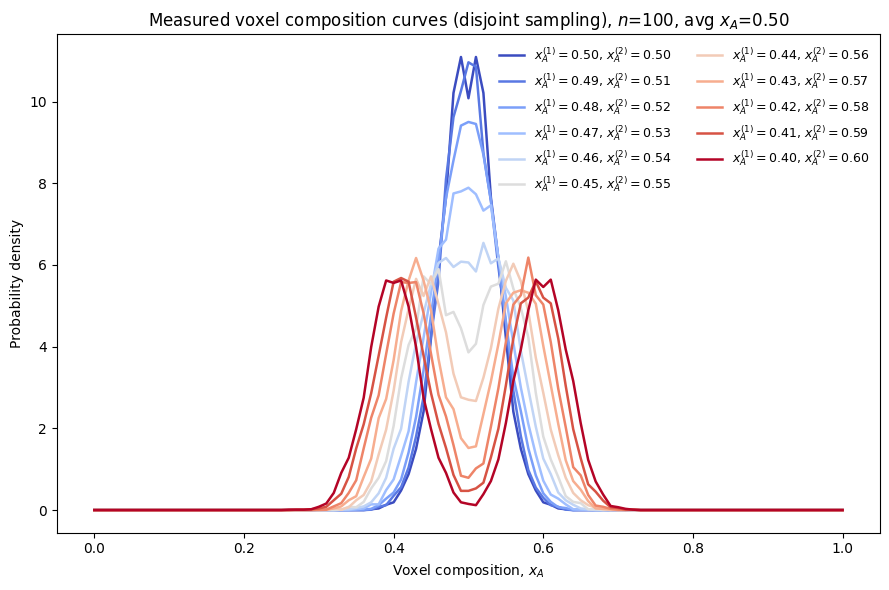

In [ ]:
# Segregated alloy: sweep Phase 1 composition (A fraction) from 0.50 → 0.40 (step -0.01)
# Generate measured voxel compositions with DISJOINT sampling and plot 11 overlaid curves.
#
# Notes
# - Uses exact fixed counts per domain (largest remainder) to preserve the global average x_A.
# - For each Phase 1 composition, Phase 2 is set to keep the same overall x_A.
# - "Curves" here are histogram lines (not bars) on the discrete support k/voxel_size.
# - Colors span red → blue across the sweep.

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ----------------------------- USER PARAMETERS ----------------------------- #
N_total        = 1_000_000   # total atoms
xA_avg         = 0.5        # global target fraction of A
domain_size    = 200         # atoms per domain (equal-sized; last may be shorter)
voxel_size     = 100         # atoms per voxel (APT equal-atom voxels)
seed_base      = 2025        # base RNG seed; per-sweep offset is added for reproducibility
# --------------------------------------------------------------------------- #

rng_master = np.random.default_rng(seed_base)

@dataclass
class SimResult:
    is_A: np.ndarray
    p1_nom: float
    p2_nom: float

def fixed_count_block(L: int, k: int, rng: np.random.Generator) -> np.ndarray:
    """Boolean block of length L with exactly k True entries, randomly permuted."""
    if not (0 <= k <= L):
        raise ValueError(f"k must be in [0, {L}], got {k}")
    block = np.empty(L, dtype=bool)
    block[:k] = True
    block[k:] = False
    rng.shuffle(block)
    return block

def largest_remainder_counts(lengths: np.ndarray, fractions: np.ndarray, total_target: int) -> np.ndarray:
    """
    Integer counts per domain close to lengths*fractions with exact sum=total_target (Hamilton method).
    """
    raw = lengths * fractions
    floors = np.floor(raw).astype(int)
    rema = raw - floors
    counts = floors.copy()
    delta = total_target - counts.sum()

    if delta > 0:
        idx = np.argpartition(-rema, delta-1)[:delta]
        counts[idx] += 1
    elif delta < 0:
        m = -delta
        idx = np.argpartition(rema, m-1)[:m]
        counts[idx] -= 1
    counts = np.clip(counts, 0, lengths)

    diff = total_target - counts.sum()
    if diff != 0:
        if diff > 0:
            for i in np.argsort(-(lengths - counts)):
                add = min(diff, lengths[i] - counts[i])
                counts[i] += add
                diff -= add
                if diff == 0: break
        else:
            diff = -diff
            for i in np.argsort(-counts):
                sub = min(diff, counts[i])
                counts[i] -= sub
                diff -= sub
                if diff == 0: break
        if diff != 0:
            raise RuntimeError("Could not reconcile totals after clipping.")
    return counts

def build_segregated_fixed(N: int, xA_avg: float, xA_p1: float, domain_size: int, seed: int) -> SimResult:
    """Alternating domains: Phase 1 at xA_p1, Phase 2 adjusted to preserve overall xA_avg. Exact integer counts."""
    rng = np.random.default_rng(seed)

    # Clamp Phase 1 nominal and compute Phase 2 to keep global average
    xA_p1 = float(np.clip(xA_p1, 0.0, 1.0))
    xA_p2 = 2.0 * xA_avg - xA_p1
    if xA_p2 < 0.0:
        xA_p2 = 0.0
        xA_p1 = 2.0 * xA_avg - xA_p2
    elif xA_p2 > 1.0:
        xA_p2 = 1.0
        xA_p1 = 2.0 * xA_avg - xA_p2
    xA_p1 = float(np.clip(xA_p1, 0.0, 1.0))
    xA_p2 = float(np.clip(xA_p2, 0.0, 1.0))

    # Domain bookkeeping
    n_domains = int(np.ceil(N / domain_size))
    lengths = np.full(n_domains, domain_size, dtype=int)
    if n_domains > 0:
        lengths[-1] = N - domain_size * (n_domains - 1)

    types = np.arange(n_domains) % 2  # 0 -> phase_1, 1 -> phase_2
    fracs = np.where(types == 0, xA_p1, xA_p2)

    total_target = int(round(N * xA_avg))
    counts = largest_remainder_counts(lengths, fracs, total_target)

    # Assemble chain
    is_A = np.empty(N, dtype=bool)
    start = 0
    for L, k in zip(lengths, counts):
        end = start + L
        is_A[start:end] = fixed_count_block(L, int(k), rng)
        start = end

    return SimResult(is_A=is_A, p1_nom=xA_p1, p2_nom=xA_p2)

def voxel_compositions_disjoint(is_A: np.ndarray, voxel_size: int) -> np.ndarray:
    """Disjoint contiguous voxels; returns compositions per voxel."""
    N = is_A.size
    n_full = N // voxel_size
    if n_full == 0: return np.array([], dtype=float)
    A_int = is_A.view(np.int8)
    cs = np.empty(N+1, dtype=np.int64); cs[0] = 0; np.cumsum(A_int, out=cs[1:])
    starts = np.arange(0, n_full * voxel_size, voxel_size, dtype=np.int64)
    ends   = starts + voxel_size
    sums = cs[ends] - cs[starts]
    return sums.astype(np.float64) / voxel_size

# Discrete support for histogram "curves" (probabilities per bin)
comp_support = np.arange(0, voxel_size + 1, dtype=float) / voxel_size

# Sweep Phase 1 compositions: 0.50 → 0.40 inclusive, step -0.01 (11 values)
p1_values = np.round(np.linspace(0.50, 0.40, 11), 2)

plt.figure(figsize=(9, 6))
cmap = plt.cm.get_cmap('coolwarm', len(p1_values))  # red→blue palette
lines = []
labels = []

for idx, p1 in enumerate(p1_values):
    # Build segregated chain for this Phase 1 nominal composition
    sim = build_segregated_fixed(N_total, xA_avg, p1, domain_size, seed=seed_base + idx)
    x_vox = voxel_compositions_disjoint(sim.is_A, voxel_size)

    # Histogram on discrete support -> normalized to probability (area=1)
    # Align bins to the discrete centers k/voxel_size
    edges = np.linspace(-0.5/voxel_size, 1 + 0.5/voxel_size, voxel_size + 2)
    counts, _ = np.histogram(x_vox, bins=edges, density=True)
    centers = (edges[:-1] + edges[1:]) / 2

    color = cmap(idx)  # red→blue across the sweep
    line, = plt.plot(centers, counts, lw=1.8, color=color)
    lines.append(line)
    labels.append(f"$x_A^{{(1)}}={p1:.2f}$, $x_A^{{(2)}}={sim.p2_nom:.2f}$")

plt.xlabel("Voxel composition, $x_A$")
plt.ylabel("Probability density")
plt.title(f"Measured voxel composition curves (disjoint sampling), $n$={voxel_size}, avg $x_A$={xA_avg:.2f}")
plt.legend(lines, labels, fontsize=9, ncol=2, frameon=False)
plt.tight_layout()
plt.show()


# Reflection and Extension: Feature Extraction

### Atom Probe Tomography of Quantum Dots

### Poisson Pre-Assignment?